# Task 1 - The Classical Computer Vision Baseline

## Loading data

The dataset is downloaded and located in the "NEU-DET" folder. The dataset can be loaded in a pandas dataframe, where we store the filepath, type and id of each image. We can split the dataset 80/20 into a training set and a validation set. 

In [17]:
# folder: ./NEU-DET/train/

import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# we have to loop through NEU-DET/train/{all 6 folders} and add the filepaths of all images inside
image_list = []
path_train = '../NEU-DET/train/images'
path_validation = '../NEU-DET/validation/images'

# get images from training
for folder in os.listdir(path_train):
    for file in os.listdir(os.path.join(path_train, folder)):
        image_list.append({'filepath': os.path.join(path_train, folder, file), 'type': file.split('_')[0], 'id': file.split('_')[-1].split('.')[0]})

# get images from validation
for folder in os.listdir(path_validation):
    for file in os.listdir(os.path.join(path_validation, folder)):
        image_list.append({'filepath': os.path.join(path_validation, folder, file), 'type': file.split('_')[0], 'id': file.split('_')[-1].split('.')[0]})

# create dataframe
df = pd.DataFrame(image_list)

# 80/20 split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['type'], random_state=7)

print("training set containing", len(train_df), "images: \n", train_df.head(), "\n")
print("validation set containing", len(val_df), "images: \n", val_df.head())



training set containing 1440 images: 
                                                filepath       type   id
419   ../NEU-DET/train/images\inclusion\inclusion_44...  inclusion   44
675      ../NEU-DET/train/images\patches\patches_59.jpg    patches   59
748   ../NEU-DET/train/images\pitted_surface\pitted_...     pitted  124
226      ../NEU-DET/train/images\crazing\crazing_87.jpg    crazing   87
1163  ../NEU-DET/train/images\rolled-in_scale\rolled...  rolled-in   66 

validation set containing 360 images: 
                                                filepath       type   id
209      ../NEU-DET/train/images\crazing\crazing_71.jpg    crazing   71
1779  ../NEU-DET/validation/images\scratches\scratch...  scratches  280
629     ../NEU-DET/train/images\patches\patches_233.jpg    patches  233
604     ../NEU-DET/train/images\patches\patches_210.jpg    patches  210
1457  ../NEU-DET/validation/images\crazing\crazing_2...    crazing  258


## Visual inspection

The first step is to inspect the type of images we are working with, to determine the best feature extraction steps for later. 

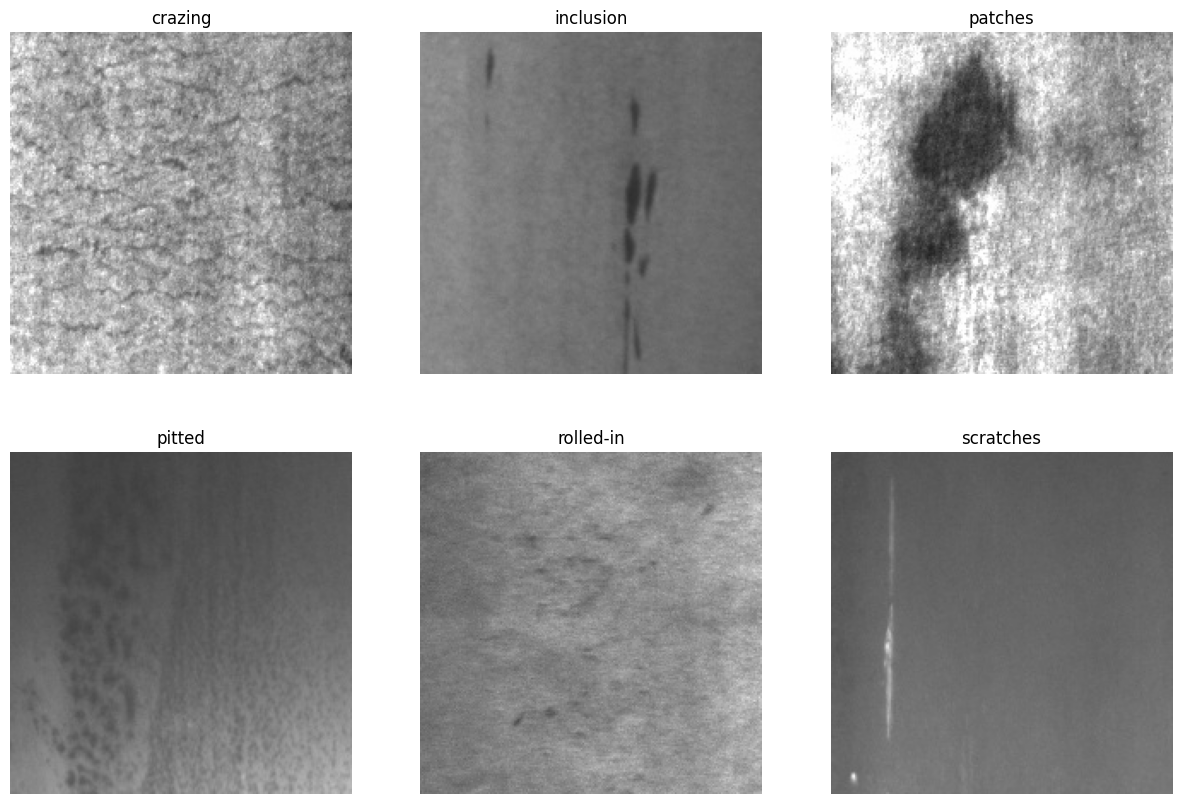

In [18]:
# get an array of the different defect types
types = df['type'].unique()

# and plot the first image of each type
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, t in enumerate(types):
    img = plt.imread(df[df['type'] == t].iloc[0]['filepath'])
    axs[i // 3, i % 3].imshow(img)
    axs[i // 3, i % 3].set_title(t)
    axs[i // 3, i % 3].axis('off')
plt.show()


The figure shows one image from each defect, displaying the types of images we will be looking at.

6 types of defects are shown: 
- Crazing - network of cracks
- Inclusion - non-metallic particles entrapped 
- Patches - large regions where texture looks different
- Pitted Surface - depressions scattered across surface
- scratches - long marks
- rolled-in - layered patches adhered to the surface

All images are greyscale, and we can already guess what some of the defects are based on intensity and shape (scratches and inclusion), or by size (patches). 

The goal is to select 2 types of features to be used for classification, where one focuses on local features like edges and gradients while the other focuses on textures. For this baseline, I selected Histogram of Oriented Gradients (HOG) and Gray-Level Co-occurence Matrix (GLCM) features as HOG is well-suited for capturing local structures like edges, lines, and gradients, while GLCM provides texture-based descriptors that capture spatial relationships between pixel intensities.

For classification, I chose a Random Forest model because it efficiently handles different types of feature sets.


 




## Histogram of oriented gradients (HOG) 

First, we implement HOG using skimage. HOG captures local edge/gradient orientation. This is a good starting point and is relatively quick to implement using the df we defined earlier. To compute the HOG we will use 8x8 pixels for a cell, and 2x2 cells for a block. The extract_hog function is defined in the following dropdown.

In [19]:
from skimage.feature import hog
from skimage.io import imread
from skimage.color import rgb2gray

def extract_hog(filepath):
    img = imread(filepath)
    if img.ndim == 3:
        img = rgb2gray(img)
    features = hog(img, 
                   orientations=8, 
                   pixels_per_cell=(8, 8), 
                   cells_per_block=(2, 2)
                )
    return features


Using the extract_hog for both the training and the validation set, we can store the resulting features in the df.

In [20]:
import numpy as np

X_train = np.vstack([extract_hog(fp) for fp in train_df["filepath"]])
y_train = train_df["type"].values

X_test = np.vstack([extract_hog(fp) for fp in val_df["filepath"]])
y_test = val_df["type"].values

# add these to the dataframe as well
train_df['hog_features'] = list(X_train)
val_df['hog_features'] = list(X_test)

print("the head of the train df: \n", train_df.head())

the head of the train df: 
                                                filepath       type   id  \
419   ../NEU-DET/train/images\inclusion\inclusion_44...  inclusion   44   
675      ../NEU-DET/train/images\patches\patches_59.jpg    patches   59   
748   ../NEU-DET/train/images\pitted_surface\pitted_...     pitted  124   
226      ../NEU-DET/train/images\crazing\crazing_87.jpg    crazing   87   
1163  ../NEU-DET/train/images\rolled-in_scale\rolled...  rolled-in   66   

                                           hog_features  
419   [0.23692369683202827, 0.15415997280614854, 0.2...  
675   [0.2932409827161144, 0.03451907966977623, 0.13...  
748   [0.25374744478784045, 0.25374744478784045, 0.2...  
226   [0.22393231707764982, 0.08401035403228327, 0.2...  
1163  [0.19847725569063174, 0.07978102076128961, 0.1...  


we can keep an eye on what sort of features we are extracting by making use of the hog_image value returned, as seen in the dropdown below.

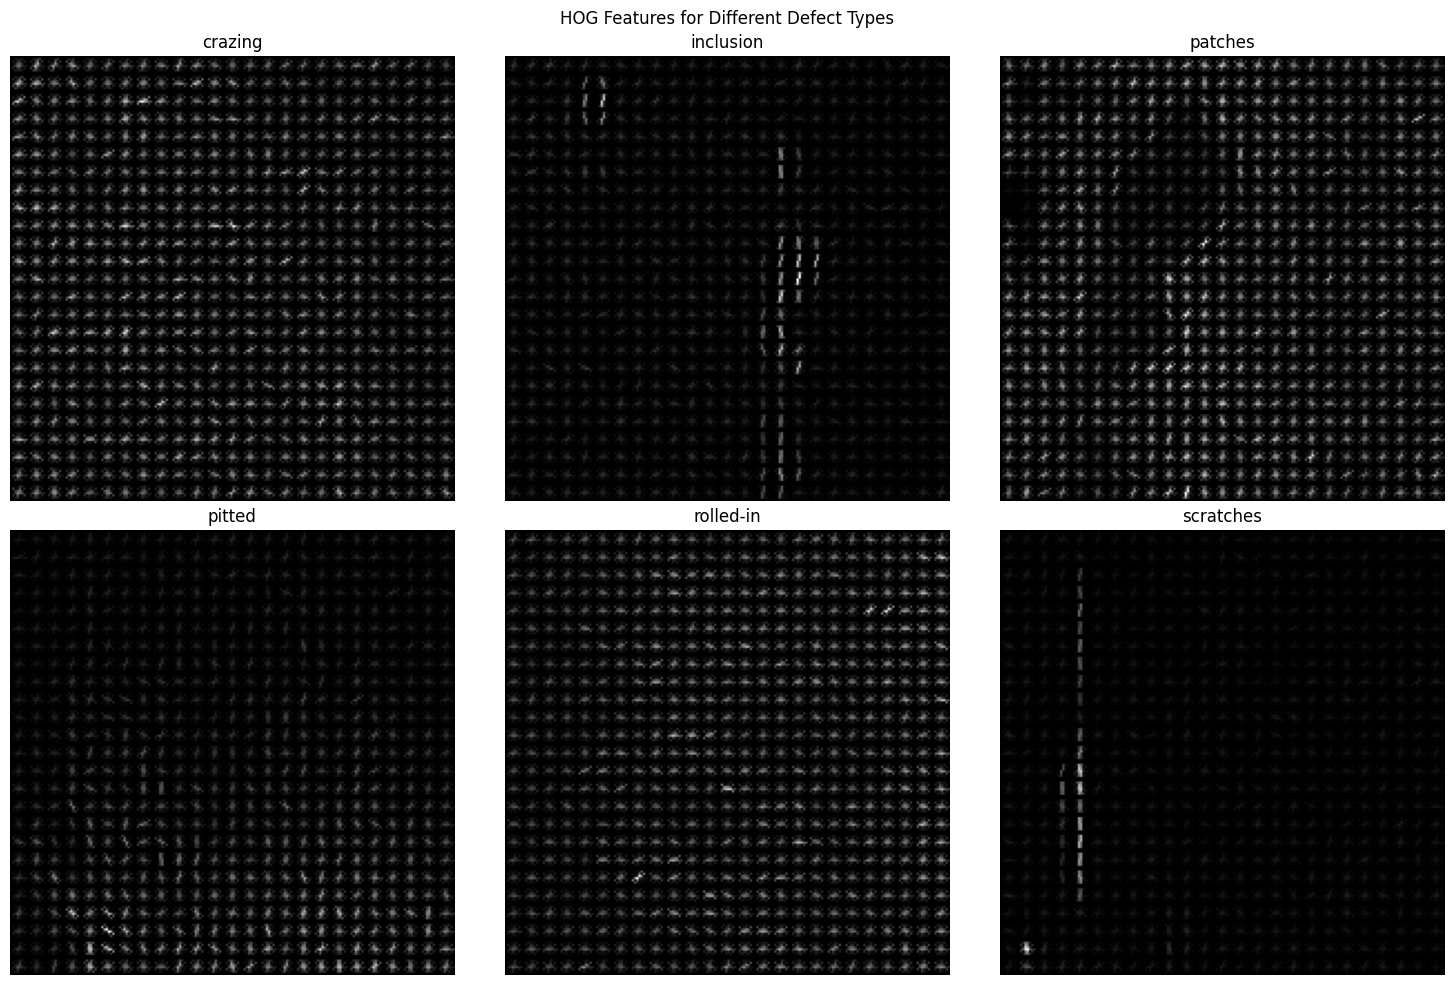

In [21]:
#| label: fig-my-plot

from skimage import exposure

# make a grid 2 rows x 3 columns (one per defect type)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, t in enumerate(types):
    # get first image for defect type
    fp = df[df['type'] == t].iloc[0]['filepath']
    img = imread(fp)
    if img.ndim == 3:
        img = rgb2gray(img)
    
    # compute HOG features with visualization
    features, hog_image = hog(
        img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True
    )
    
    # rescale HOG image for display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, hog_image.max()))
    
    # plot HOG map
    axs[i // 3, i % 3].imshow(hog_image_rescaled, cmap='gray')
    axs[i // 3, i % 3].set_title(f"{t}")
    axs[i // 3, i % 3].axis('off')

fig.suptitle("HOG Features for Different Defect Types")
plt.tight_layout()
plt.show()

From visual inspection we can already see how the HOG features will allow a classification algorithm to easily distinguish between scratches and inclusions, and the other defects. It will also be expected to lack information regarding the other individual defects as they look quite similar.

## Classification - Random Forest

To classify the images, we will use Random Forest (RF) classification. As RF is based on a decision tree, there are few parameters to tune which is ideal for an experimental-based task like we are doing now. We can implement a RF classifier using 200 estimators and random_state = 1 to get similar results on each run: 

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Prepare features and labels from the DataFrames
X_rf_train = np.vstack(train_df['hog_features'].values)
y_rf_train = train_df['type'].values

X_rf_val = np.vstack(val_df['hog_features'].values)
y_rf_val = val_df['type'].values

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=1)
rf.fit(X_rf_train, y_rf_train)

# Predict on validation set
y_pred = rf.predict(X_rf_val)

# Print accuracy and classification report
print("Validation Accuracy:", accuracy_score(y_rf_val, y_pred))
print("classification report: \n", classification_report(y_rf_val, y_pred))

Validation Accuracy: 0.7222222222222222
classification report: 
               precision    recall  f1-score   support

     crazing       0.67      0.90      0.77        60
   inclusion       0.68      0.82      0.74        60
     patches       0.60      0.42      0.49        60
      pitted       0.65      0.58      0.61        60
   rolled-in       0.94      1.00      0.97        60
   scratches       0.79      0.62      0.69        60

    accuracy                           0.72       360
   macro avg       0.72      0.72      0.71       360
weighted avg       0.72      0.72      0.71       360



A confusion matrix can be generated using the validation set

In [23]:
cm = confusion_matrix(y_rf_val, y_pred)
cm_df = pd.DataFrame(cm, index=types, columns=types)
print("Confusion Matrix:\n", cm_df)

Confusion Matrix:
            crazing  inclusion  patches  pitted  rolled-in  scratches
crazing         54          0        6       0          0          0
inclusion        0         49        0       6          0          5
patches         21          0       25      13          0          1
pitted           5          5       11      35          0          4
rolled-in        0          0        0       0         60          0
scratches        1         18        0       0          4         37


## Sanity check: mid-point evaluation

Based on the classification using just the HOG feature, we can see where the RF model makes mistakes. This allows us to more accurately determine the second feature we can use to increase the accuracy. 

First to note is the poor performance recognising the difference between pitted surfaces and patches. This is most likely due to the HOG features only containing information about gradients, and less about broader shapes and sizes. 

We can add Grey-level Co-occurance Matrix (GLCM) features to try and supplement the HOG features. GLCM counts how often pairs of pixel intensities occur at a given distance and direction, turning those co-occurrence patterns into texture descriptors. 

## Gray-Level Co-occurrence Matrix (GLCM)

We can also implement GLCM using the skimage library. We define a GLCM function with preset distances [1,2,4,8] and angles [0, np.pi/4, np.pi/2, 3*np.pi/4]: 

In [24]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops
import numpy as np

# function to extract GLCM features, 
def extract_glcm(filepath, distances=[1,2,4,8], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):

    img = imread(filepath)
    if img.ndim == 3:
        img = rgb2gray(img)
    
    # Convert to 8-bit grayscale (0-255)
    img = (img * 255).astype(np.uint8)
    
    # Compute GLCM
    glcm = graycomatrix(img, distances=distances, angles=angles, symmetric=True, normed=True)
    
    # Extract features
    feats = []
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    for prop in props:
        vals = graycoprops(glcm, prop)
        feats.extend(vals.flatten())
    
    return np.array(feats)

This function can be applied to each image in the dataset

In [25]:
# Training set
X_glcm_train = np.vstack([extract_glcm(fp) for fp in train_df['filepath']])
train_df['glcm_features'] = list(X_glcm_train)

# Validation/test set
X_glcm_val = np.vstack([extract_glcm(fp) for fp in val_df['filepath']])
val_df['glcm_features'] = list(X_glcm_val)

print("all images processed, head of train df: \n", train_df.head())

all images processed, head of train df: 
                                                filepath       type   id  \
419   ../NEU-DET/train/images\inclusion\inclusion_44...  inclusion   44   
675      ../NEU-DET/train/images\patches\patches_59.jpg    patches   59   
748   ../NEU-DET/train/images\pitted_surface\pitted_...     pitted  124   
226      ../NEU-DET/train/images\crazing\crazing_87.jpg    crazing   87   
1163  ../NEU-DET/train/images\rolled-in_scale\rolled...  rolled-in   66   

                                           hog_features  \
419   [0.23692369683202827, 0.15415997280614854, 0.2...   
675   [0.2932409827161144, 0.03451907966977623, 0.13...   
748   [0.25374744478784045, 0.25374744478784045, 0.2...   
226   [0.22393231707764982, 0.08401035403228327, 0.2...   
1163  [0.19847725569063174, 0.07978102076128961, 0.1...   

                                          glcm_features  
419   [12.780653266331631, 17.25441276735443, 8.2350...  
675   [307.57419597989616, 426.07954

## Classification - Random Forrest

Run the RF classification algorithm again, this time using both the HOG features and the GLCM features. This results in the following classification report: 

In [26]:
# Concatenate HOG + GLCM for each image
X_train_combined = np.vstack([
    np.hstack((hog_feat, glcm_feat))
    for hog_feat, glcm_feat in zip(train_df['hog_features'], train_df['glcm_features'])
])

X_val_combined = np.vstack([
    np.hstack((hog_feat, glcm_feat))
    for hog_feat, glcm_feat in zip(val_df['hog_features'], val_df['glcm_features'])
])

# Labels
y_train = train_df['type'].values
y_val = val_df['type'].values

# Initialize RF (class_weight='balanced' is optional if some classes are rarer)
rf = RandomForestClassifier(n_estimators=100, random_state=1)

# Train
rf.fit(X_train_combined, y_train)

# Predict on validation set
y_pred = rf.predict(X_val_combined)

# Print accuracy and classification report
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

# add classification report to df  
report = classification_report(y_val, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()



Validation Accuracy: 0.8972222222222223
              precision    recall  f1-score   support

     crazing       0.91      0.85      0.88        60
   inclusion       0.82      0.97      0.89        60
     patches       0.85      0.92      0.88        60
      pitted       0.88      0.77      0.82        60
   rolled-in       1.00      1.00      1.00        60
   scratches       0.95      0.88      0.91        60

    accuracy                           0.90       360
   macro avg       0.90      0.90      0.90       360
weighted avg       0.90      0.90      0.90       360



With the following confusion matrix: 

In [27]:
# get confusion matrix
cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=types, columns=types)
print("Confusion Matrix:\n", cm_df)

Confusion Matrix:
            crazing  inclusion  patches  pitted  rolled-in  scratches
crazing         51          0        8       1          0          0
inclusion        0         58        0       1          0          1
patches          1          0       55       4          0          0
pitted           4          6        2      46          0          2
rolled-in        0          0        0       0         60          0
scratches        0          7        0       0          0         53


In [28]:
# how many input features for RF
print("Number of input variables for RF:", X_train_combined.shape[1])

Number of input variables for RF: 18512


In [29]:
# save report_df
report_df.to_csv('task1_classification_report.csv', index=True)

## Conclusion 

After the sanity check we have successfully improved the model by also looking at the GLCM features. The model now more accurately distinguishes between patches and pitted surfaces. The overall precision increased from an average of 0.72 to an average of 0.90. While small discrepancies remain, there is no recurring error for a specific class. For each of the classes, the F1-Score is quite similar to the precision and the recall, indicating the model neither over-predicts nor under-predicts. This shows the model is making balanced predictions for all defect types.

The codecells below will save any relevant information to be taken to tasks 2 and 3.

In [30]:
# Save all dataframes to be used in Task 2 and 3.

train_df.to_csv('train_dataframe.csv')
val_df.to_csv('val_dataframe.csv')

# save confusion matrix and report to file
cm_df.to_csv('confusion_matrix.csv')


### sidenote

The below code has been run to analyse and select 3 images to be displayed in task 3. This code does not run in the MYST book, only when opened as a notebook. 

In [31]:
# generate an interactive plot, where we can scroll through all misclassified images and see what index they are at
import ipywidgets as widgets
from IPython.display import display

# get indices of misclassified images
misclassified_indices = np.where(y_val != y_pred)[0]

# interactive function to display image and its info
def show_image(index):
    if index < 0 or index >= len(misclassified_indices):
        print("Index out of range")
        return
    actual_index = misclassified_indices[index]
    img = imread(val_df.iloc[actual_index]['filepath'])
    plt.imshow(img, cmap='gray')
    plt.title(f"Index: {actual_index}, Actual: {y_val[actual_index]}, Predicted: {y_pred[actual_index]}")
    plt.axis('off')
    plt.show()
slider = widgets.IntSlider(value=0, min=0, max=len(misclassified_indices)-1, step=1, description='Image Index:')
widgets.interact(show_image, index=slider)

# 9 - big dark patches
# 11 - scratches/inclusion
# 21


interactive(children=(IntSlider(value=0, description='Image Index:', max=36), Output()), _dom_classes=('widget…

<function __main__.show_image(index)>

Selecting images based on the challenges we want to focus on: 
1) patch classified as pitted - very little detail can be seen, repeating dark pattern
2) scratch classified as inclusion - similar to the model in task 2
3) pitted classified as inclusion - a lot is going on, with both features and a general gradient in light

In [32]:
# make a new df of misclassified images indices 9 11 and 21
actual_indices = misclassified_indices[[9, 11, 21]].copy()
misclassified_samples = val_df.iloc[actual_indices]
misclassified_samples['predicted_type'] = y_pred[actual_indices]

misclassified_samples.to_csv('misclassified_images_1.csv', index=False)

C:\Users\luukf\AppData\Local\Temp\ipykernel_28204\709528826.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_samples['predicted_type'] = y_pred[actual_indices]
